In [1]:

%pprint

Pretty printing has been turned OFF


In [2]:

import sys

# Insert at 1, 0 is the script path (or '' in REPL)
sys.path.insert(1, '../py')

from storage import Storage
from stats_scraping_utils import StatsScrapingUtilities

s = Storage()
ssu = StatsScrapingUtilities(s=s)

C:\ProgramData\Anaconda3\lib\site-packages\pydub\utils.py:170: RuntimeWarning: Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work
  warn("Couldn't find ffmpeg or avconv - defaulting to ffmpeg, but may not work", RuntimeWarning)


In [3]:

import os

xname = 'Overall Capitalism'
pickle_name_list = []
for file_name in os.listdir(s.saves_pickle_folder):
    pickle_name = file_name.split('.')[0]
    if pickle_name.endswith('_df'):
        eval_str = f"s.load_object('{pickle_name}')"
        df = eval(eval_str)
        if xname in df.columns:
            print(eval_str, df.shape)
            pickle_name_list.append(pickle_name)

s.load_object('capitalism_gini_df') (160, 13)


In [4]:

capitalism_gini_df = s.load_object('capitalism_gini_df')
capitalism_gini_df.sample(8).T

,22,104,146,57,111,28,66,56
Rank,25.0,118.0,162,62,125.0,31.0,73,61
Country,United States,Saudi Arabia,Lebanon,Brunei,Dominica,Portugal,Paraguay,Botswana
Overall Capitalism,72.1,55.5,47.3,64.8,54.4,70.8,62.9,64.8
Change,-2.7,-10.5,-4.1,-1.8,1.4,3.3,0.3,-2.8
Adults (thousand),245_140,23_208,4_205,304,55,8_373,4_268,1_409
Mean wealth per adult (USD),432_365,67_032,55_226,44_541,33_306,131_088,11_865,14_684
Median wealth per adult (USD),65_904,16_599,12_198,13_634,9_447,44_025,3_887,4_550
Distribution of adults (%) by wealth range (USD) (under 10_000),26.9,41.4,45.2,44.0,52.0,14.7,75.6,73.0
Distribution of adults (%) by wealth range (USD) (10_000 - 100_000),31.0,47.8,46.0,49.6,42.8,54.7,23.1,24.8
Distribution of adults (%) by wealth range (USD) (100_000 – 1 million),34.5,10.2,8.2,6.0,4.9,29.3,1.2,2.1


In [5]:

# This is HTML from https://www.transparency.org/en/cpi/2021
file_path = '../data/html/corruption_perceptions_index.html'
table_dfs_list = ssu.get_page_tables(file_path, verbose=True)

[(0, (181, 3))]


In [6]:

corruption_df = table_dfs_list[0].copy()
corruption_df.columns = corruption_df.loc[0].tolist()
corruption_df = corruption_df.loc[1:]
corruption_df.columns = ['Corruption_Score', 'Country', 'Corruption_Rank']
corruption_df.sample(5)

,Corruption_Score,Country,Corruption_Rank
105,36,Cote d'Ivoire,105
114,35,Thailand,110
139,29,Russia,136
138,29,Mali,136
58,49,Armenia,58


In [7]:

len(set(capitalism_gini_df.Country).intersection(set(corruption_df.Country)))

152

In [8]:

countries_list = sorted(set(capitalism_gini_df.Country).symmetric_difference(set(corruption_df.Country)))
doubles_df = ssu.check_4_doubles(countries_list)
mask_series = (doubles_df.max_similarity > 0.6)
columns_list = ['first_item', 'second_item', 'max_similarity']
[(row_dict['first_item'], row_dict['second_item']) for row_dict in doubles_df[mask_series][columns_list].sort_values('max_similarity',
                                                                                                                     ascending=False).to_dict(orient='records')]

[('Guinea Bissau', 'Guinea-Bissau'), ('Korea, North', 'Korea, South'), ('United States', 'United States of America'), ('Democratic Republic of the Congo', 'Republic of Congo')]

In [9]:

columns_list_dict = {
    'DRC': ['Democratic Republic of Congo', 'Democratic Republic of the Congo', 'Congo, Democratic Republic of the'],
    'Guinea-Bissau': ['Guinea Bissau'],
    'USA': ['United States of America', 'United States']
}
for df in [capitalism_gini_df, corruption_df]:
    for good_country_name, countries_list in columns_list_dict.items():
        for bad_country_name in countries_list:
            mask_series = (df.Country == bad_country_name)
            df.loc[mask_series, 'Country'] = good_country_name
s.store_objects(capitalism_gini_df=capitalism_gini_df, corruption_df=corruption_df)

Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\StatsByCountry\saves\pkl\capitalism_gini_df.pkl
Pickling to C:\Users\daveb\OneDrive\Documents\GitHub\StatsByCountry\saves\pkl\corruption_df.pkl


In [10]:

columns_list = ['Country', 'Overall Capitalism']
merge_df = corruption_df.merge(capitalism_gini_df[columns_list], on='Country', how='inner')
merge_df.sample(5)

,Corruption_Score,Country,Corruption_Rank,Overall Capitalism
131,27,Uganda,144,54.2
127,28,Mauritania,140,55.3
135,25,Guinea,150,54.2
53,49,Jordan,58,60.1
128,28,Pakistan,140,48.8


In [11]:

import matplotlib.pyplot as plt
import textwrap
import seaborn as sns
%matplotlib inline

# Use the following only if you are on a high definition device
from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

# Explanatory variable
xname = 'Overall Capitalism'

# Response variable
yname = 'Corruption_Score'

# Remove NaNs
columns_list = ['Country', xname, yname]
df = merge_df[columns_list].dropna()
df[yname] = df[yname].map(lambda x: float(x))
xdata = df[xname]
ydata = df[yname]

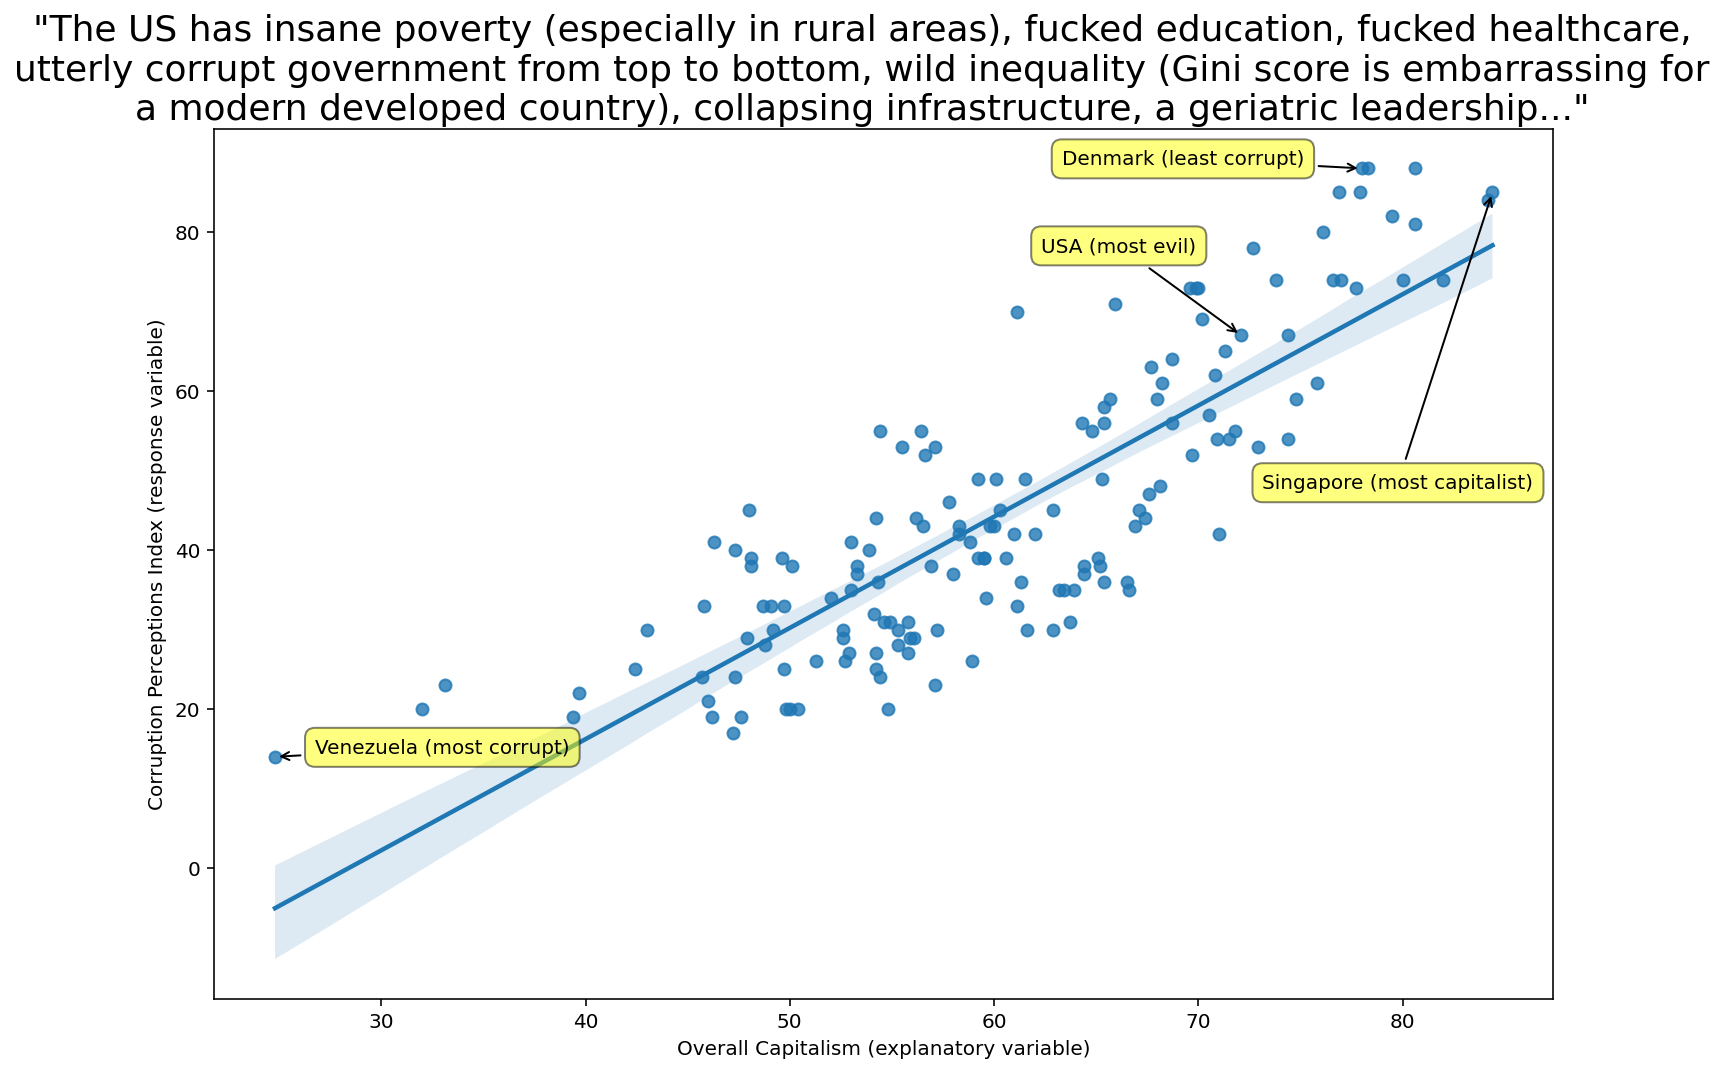

In [16]:

# First order (linear) scatterplot
fig1_fig = plt.figure(figsize=(12,8))
merge_axes_subplot = sns.regplot(x=xname, y=yname, scatter=True, data=df)
xlabel_str = 'Overall Capitalism (explanatory variable)'
xlabel_text = plt.xlabel(xlabel_str)
ylabel_str = 'Corruption Perceptions Index (response variable)'
ylabel_text = plt.ylabel(ylabel_str)
kwargs = dict(textcoords='offset points', ha='left', va='bottom',
              bbox=dict(boxstyle='round,pad=0.5', fc='yellow', alpha=0.5),
              arrowprops=dict(arrowstyle='->', connectionstyle='arc3,rad=0'))
least_capitalist = xdata.min()
most_capitalist = xdata.max()
most_corrupt = ydata.min()
least_corrupt = ydata.max()
least_corrupt_found = False
for label, x, y in zip(df['Country'], xdata, ydata):
    if (y == most_corrupt):
        annotation = plt.annotate('{} (most corrupt)'.format(label),
                                  xy=(x, y), xytext=(20, 0), **kwargs)
    elif (y == least_corrupt) and not least_corrupt_found:
        least_corrupt_found = True
        annotation = plt.annotate('{} (least corrupt)'.format(label),
                                  xy=(x, y), xytext=(-150, 0), **kwargs)
    elif (x == least_capitalist):
        annotation = plt.annotate('{} (least capitalist)'.format(label),
                                  xy=(x, y), xytext=(0, 0), **kwargs)
    elif (x == most_capitalist):
        annotation = plt.annotate('{} (most capitalist)'.format(label),
                                  xy=(x, y), xytext=(-115, -150), **kwargs)
    elif (label == 'USA'):
        annotation = plt.annotate('{} (most evil)'.format(label),
                                  xy=(x, y), xytext=(-100, 40), **kwargs)
title_str = '"The US has insane poverty (especially in rural areas), fucked education, '
title_str += 'fucked healthcare, utterly corrupt government from top to bottom, '
title_str += 'wild inequality (Gini score is embarrassing for a modern developed country), '
title_str += 'collapsing infrastructure, a geriatric leadership..."'
wrapped_lines = textwrap.wrap(title_str, width=len(title_str)//3+5)
title_obj = fig1_fig.suptitle('\n'.join(wrapped_lines), fontsize=18)